In [1]:
# attempt to fit a disk model to NGC4261
import numpy as np
import astropy.units as u
from radiation import *

import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.coordinates import Distance

In [2]:
# general variables
sed_x_label = r"$\nu\,/\,{\rm Hz}$"
sed_y_label = r"$\nu F_{\nu}\,/\,({\rm erg}\,{\rm cm}^{-2}\,{\rm s}^{-1})$"

In [3]:
# load the data and plot them
sed_table = Table.read("data/NGC4261_final_table.fits")
x = sed_table["col1"]
y = sed_table["col3"]
yerr = sed_table["col4"]

# define the data eliminating measurements with zero error
mask_error = yerr > 0
mask_lower_limit = y > 1e-14
mask = mask_error * mask_lower_limit
x_new = sed_table["col1"][mask]
y_new = sed_table["col3"][mask]
yerr_new = sed_table["col4"][mask]

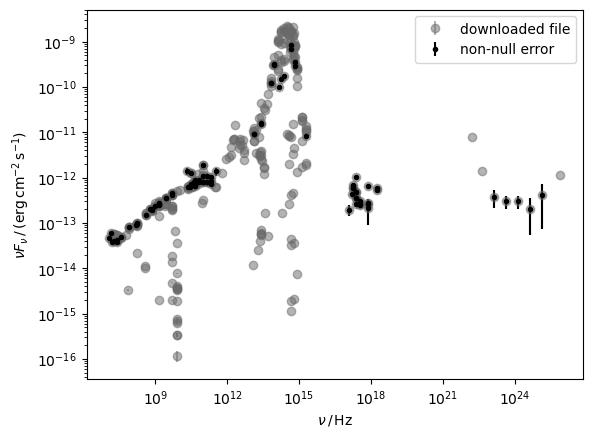

In [4]:
fig, ax = plt.subplots()
ax.errorbar(
    x,
    y,
    yerr=yerr,
    ls="",
    marker="o",
    color="dimgray",
    alpha=0.5,
    label="downloaded file"
)
ax.errorbar(
    x_new,
    y_new,
    yerr=yerr_new,
    ls="",
    marker=".",
    color="k",
    label="non-null error"
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(sed_x_label)
ax.set_ylabel(sed_y_label)
ax.legend()
plt.show()

In [11]:
# define a new function fir the total flux
# that depends on a single array of frequencies
def nu_fnu_disk(nu, m, m_dot, d_L, norm=1):
    """Compute the total flux.
    I allow an arbitrary scaling via norm parameter, default is 1.
    """
    T_calc = compute_T_e_equilibirum(m, m_dot)

    # compute parameters
    _x_m = x_m_appendix_B(m_dot)
    _alpha_c = alpha_c(theta_from_T(T_calc * u.K), m_dot)
    # compute "break" frequency
    nu_p = vp(_x_m, m_dot, m, theta_from_T(T_calc * u.K)).value

    # let us use a switch on the three emission mechanisms
    luminosity = np.where(
        nu <= nu_p, 
        L_synch(nu, m, m_dot, _x_m, T_calc),
        L_bremms(nu, T_calc, m, m_dot) + L_compton(nu, nu_p, _alpha_c, m, m_dot, _x_m, T_calc)
    )

    sed = nu *  luminosity / (4 * np.pi * d_L**2)
    return norm * sed

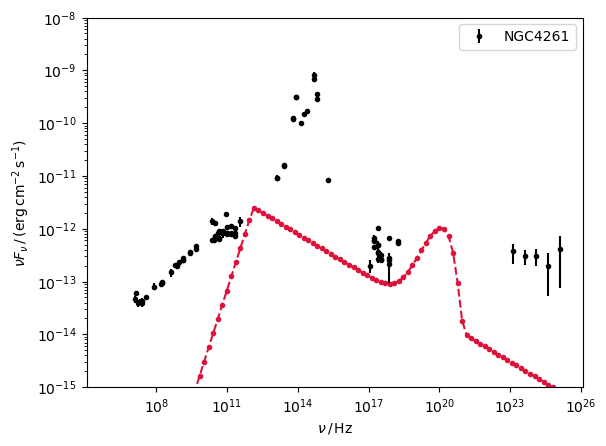

In [22]:
# let us overplot just one disk model to compare with the data
# sort of an initial guess
m = 5.2e8
m_dot = 1e-3
norm = 10
d_L = Distance(z=0.00731).to_value("cm")

# compute the model over an arbitrary array of frequencies
nu = np.logspace(6, 25, 100)

# plot now both the model and the points with errors
fig, ax = plt.subplots()
ax.plot(
    nu,
    nu_fnu_disk(nu, m, m_dot, d_L, norm),
    color="crimson",
    ls="--",
    marker="."
)
ax.errorbar(
    x_new,
    y_new,
    yerr=yerr_new,
    ls="",
    marker=".",
    color="k",
    label="NGC4261"
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(sed_x_label)
ax.set_ylabel(sed_y_label)
ax.legend()
ax.set_ylim([1e-15, 1e-8])
plt.show()

In [ ]:
class DiskEmission(RegriddableModel1D):
    """
    """

    def __init__(self, name='disk emission'):

        self.m = Parameter(name, 'm', 0)
        self.m_dot = Parameter(name, 'm_dot', -1)
        self.norm = Parameter(name, 'norm', -1)

        return RegriddableModel1D.__init__(self, name, (self.m, self.m_dot, self.norm))

    def calc(self, pars, *args, **kwargs):
        """Calculate the model"""

        # Tell the exp model to evaluate the model, after converting
        # the parameter values to the required form, and order, of:
        # offset, coeff, ampl.
        #
        coeff = pars[1]
        offset = -1 * pars[0] / coeff
        ampl = 1.0
        return self._exp.calc([offset, coeff, ampl], *args, **kwargs)

    # en  nuestro caso
    # nu_fnu_disk(nu, m, m_dot, d_L, norm=1)
    pars = (m, m_dot, d_L)